# San Francisco AirBnB data analysis
## 1. Business Understanding
This notebook explores the following high level business questions using data from http://insideairbnb.com/get-the-data.html :
1) What months are busiest in San Francisco? What are the price variations?
This helps us understand the peak months and prices for the same
2) What types of rooms are available? What is the price difference according to room type?
This helps in understanding the options of housings and the prices for the same.
3) Which neighbourhood has most listings? Is price related to the number of listings in that neighbourhood?
This helps in understanding the neighborhoods and prices for the same.

## Data Understanding

In [26]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import calendar
warnings.filterwarnings("ignore")

%matplotlib inline


In [27]:
#Ingest calendar,listing and review data
sf_calendar = pd.read_csv('calendar.csv',parse_dates=['date'])
sf_listings = pd.read_csv('listings.csv')
sf_reviews = pd.read_csv('reviews.csv',parse_dates=['date'])
sf_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,958,2019-12-04,f,$135.00,$135.00,1.0,30.0
1,958,2019-12-05,f,$135.00,$135.00,1.0,30.0
2,958,2019-12-06,f,$135.00,$135.00,1.0,30.0
3,958,2019-12-07,f,$135.00,$135.00,1.0,30.0
4,958,2019-12-08,f,$135.00,$135.00,1.0,30.0


In [28]:
#change true and false as 1 and 0 respectively for considering only available==1 entries
replace_map = {'available':{'f': 0,'t' : 1}}
sf_calendar.replace(replace_map, inplace=True)
sf_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,958,2019-12-04,0,$135.00,$135.00,1.0,30.0
1,958,2019-12-05,0,$135.00,$135.00,1.0,30.0
2,958,2019-12-06,0,$135.00,$135.00,1.0,30.0
3,958,2019-12-07,0,$135.00,$135.00,1.0,30.0
4,958,2019-12-08,0,$135.00,$135.00,1.0,30.0


In [29]:
sf_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,958,"Bright, Modern Garden Unit - 1BR/1B",1169,Holly,NaN,Western Addition,37.76931,-122.43386,Entire home/apt,170,1,226,2019-11-17,1.79,1,71
1,3850,Charming room for two,4921,Kevin,NaN,Inner Sunset,37.75402,-122.45805,Private room,99,1,175,2019-12-01,1.38,3,74
2,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74511,-122.42102,Entire home/apt,235,30,111,2017-08-06,0.86,1,1
3,7918,A Friendly Room - UCSF/USF - San Francisco,21994,Aaron,NaN,Haight Ashbury,37.76669,-122.45250,Private room,65,32,18,2019-09-10,0.14,9,365
4,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76487,-122.45183,Private room,65,32,8,2018-09-12,0.13,9,365


In [30]:
sf_reviews.head()

,listing_id,date
0,958,2009-07-23
1,958,2009-08-03
2,958,2009-09-27
3,958,2009-11-05
4,958,2010-02-13


In [31]:
print(sf_calendar.describe())
print(sf_listings.info())

         listing_id     available  minimum_nights  maximum_nights
count  3.114335e+06  3.114335e+06    3.114309e+06    3.114309e+06
mean   2.138650e+07  4.472932e-01    1.174129e+04    1.019015e+06
std    1.283859e+07  4.972143e-01    1.082530e+06    4.649850e+07
min    9.580000e+02  0.000000e+00    1.000000e+00    1.000000e+00
25%    9.760014e+06  0.000000e+00    2.000000e+00    2.900000e+01
50%    2.259754e+07  0.000000e+00    4.000000e+00    3.600000e+02
75%    3.270356e+07  1.000000e+00    3.000000e+01    1.125000e+03
max    4.056928e+07  1.000000e+00    1.000000e+08    2.147484e+09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8533 entries, 0 to 8532
Data columns (total 16 columns):
id                                8533 non-null int64
name                              8533 non-null object
host_id                           8533 non-null int64
host_name                         8479 non-null object
neighbourhood_group               0 non-null float64
neighbourhood               

## Data Preparation
#### In this setion, we drop 2 columns a) 'neighbourhood_group' from sf_listings as it has only NaN values b) 'adjusted_price' from sf_calendar as it has the same values as 'price'

In [6]:
# remove redundant columns like neigbourhood_group from listings and adjusted_price from calendar
sf_listings = sf_listings.drop(columns = ['neighbourhood_group'])
sf_calendar = sf_calendar.drop(['adjusted_price'],axis=1)

#check the sizes of the dataset
print('Listings :{}'.format(sf_listings.shape))
print('Reviews :{}'.format(sf_reviews.shape))
print('Calendar :{}'.format(sf_calendar.shape))

Listings :(8533, 15)
Reviews :(382156, 2)
Calendar :(3114335, 6)


## 1. What months are busiest in San Francisco? What are the price variations?

### Busiest Months in San Francisco

In [7]:
# make new dataframe for number of reviews
rev_freq = pd.DataFrame(sf_reviews['date'].value_counts().values,
                        index=sf_reviews['date'].value_counts().index,
                        columns=['Number of reviews'])

# resample data grouping by year
rev_freq_year = rev_freq.resample('A').sum()
# Print values
rev_freq_year

,Number of reviews
2009-12-31,46
2010-12-31,410
2011-12-31,1786
2012-12-31,3901
2013-12-31,8491
2014-12-31,18717
2015-12-31,30756
2016-12-31,49333
2017-12-31,68745
2018-12-31,91148


In [8]:
#Finding out the earliest and latest review date
sf_reviews['StartDate'] = pd.to_datetime(sf_reviews['date'])
least_recent_date = sf_reviews['StartDate'].min()
recent_date = sf_reviews['StartDate'].max()
print(least_recent_date)
print(recent_date)

2009-05-03 00:00:00
2019-12-04 00:00:00


In [9]:
# Select the year 2018
rev_freq_2018 = rev_freq.loc['2018']
# The review sum per month
rev_2018_month = rev_freq_2018.resample('M').sum()
rev_2018_month['% rev'] = (rev_2018_month['Number of reviews']*100)/rev_2018_month['Number of reviews'].sum()
# Print values
rev_2018_month

,Number of reviews,% rev
2018-01-31,5811,6.375346
2018-02-28,5475,6.006714
2018-03-31,7121,7.812569
2018-04-30,7157,7.852065
2018-05-31,8251,9.052311
2018-06-30,8010,8.787905
2018-07-31,8937,9.804933
2018-08-31,9312,10.216351
2018-09-30,9266,10.165884
2018-10-31,9505,10.428095


In [13]:
def bar_plot(X,Y,x_label,y_label,title) :
    """
    Description: This function can be used to plot bar plots.

    Arguments:
    X = values to be plotted on x-axis
    Y = values to be plotted on y-axis
    x_label = Label to be placed near x-axis
    y_label = Label to be placed near y-axis
    title = title of plot

    Returns:
    None
    """ 
# Bar plot
    fig1 = plt.figure(figsize=(10, 5))
    ax = fig1.add_subplot(1, 1, 1, aspect='auto')
    sns.barplot(x=X, y=Y)

# Set axis label properties
    ax.set_xlabel(x_label, weight='normal', size=20)
    ax.set_ylabel(y_label, weight='normal', size=20)
    plt.title(title, fontsize=20)

# Set tick label properties
    ax.tick_params('x', labelsize=15, rotation=35)
    ax.tick_params('y', labelsize=15)
    plt.show()
    
    

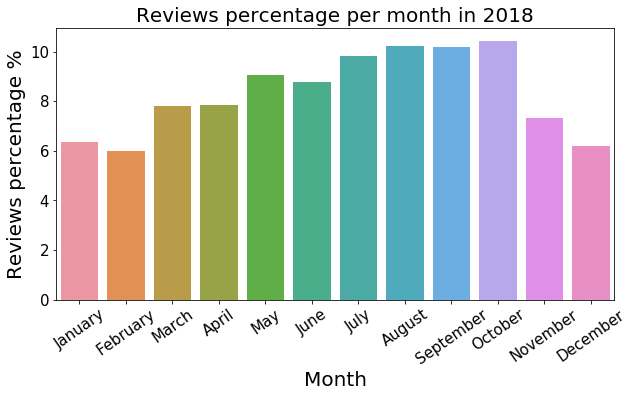

In [14]:
bar_plot(rev_2018_month.index.month_name(),rev_2018_month['% rev'],'Month','Reviews percentage %',
         'Reviews percentage per month in 2018')

In [16]:
# Select the year 2019
rev_freq_2019 = rev_freq.loc['2019']
# The review sum per month
rev_2019_month = rev_freq_2019.resample('M').sum()
rev_2019_month['% rev'] = (rev_2019_month['Number of reviews']*100)/rev_2019_month['Number of reviews'].sum()
# Print values
rev_2019_month


,Number of reviews,% rev
2019-01-31,7811,7.177711
2019-02-28,7683,7.060088
2019-03-31,9211,8.464203
2019-04-30,9101,8.363122
2019-05-31,10434,9.588047
2019-06-30,10290,9.455722
2019-07-31,10156,9.332586
2019-08-31,11619,10.676971
2019-09-30,12111,11.129081
2019-10-31,11406,10.481240


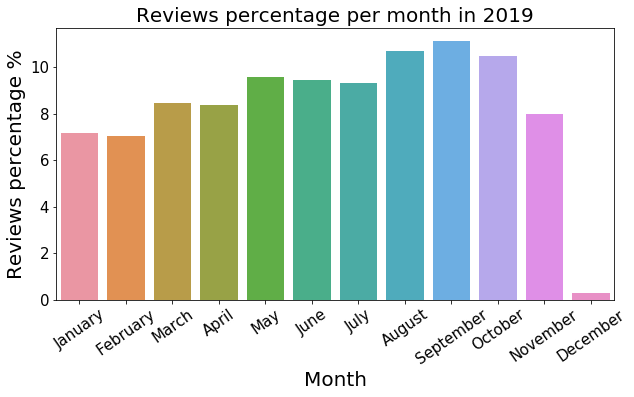

In [17]:
bar_plot(rev_2019_month.index.month_name(),rev_2019_month['% rev'],'Month','Reviews percentage %',
         'Reviews percentage per month in 2019')


#### Result : August, September and October are the busiest months.

### Price Variations

In [18]:
#Remove all rows which have 0 for availibility as they cannot influence price
sf_calendar_copy = sf_calendar.copy()
sf_calendar_copy = sf_calendar_copy[sf_calendar_copy['available']==1]

In [19]:
# Number of price listings per year
freq_cal = pd.DataFrame(sf_calendar_copy['date'].value_counts().values,
                        index=sf_calendar_copy['date'].value_counts().index,
                        columns=['Frequency of Price'])
freq_year_cal = freq_cal.resample('A').sum()
# Print values
freq_year_cal

,Frequency of Price
2019-12-31,91954
2020-12-31,1301067


In [20]:
#start and end date of entries in calendar.csv
sf_calendar_copy['StartDate'] = pd.to_datetime(sf_calendar_copy['date'])
least_recent_date = sf_calendar_copy['StartDate'].min()
recent_date = sf_calendar_copy['StartDate'].max()
print(least_recent_date)
print(recent_date)

2019-12-04 00:00:00
2020-12-03 00:00:00


In [21]:
# Index data by date
sf_calendar_copy.index = sf_calendar_copy['date']

# Get data for 2020
sf_calendar_2020 = sf_calendar_copy.loc['2020']

# Percentage of missing values
sf_calendar_2020.isnull().mean()

listing_id        0.000000
date              0.000000
available         0.000000
price             0.000098
minimum_nights    0.000000
maximum_nights    0.000000
StartDate         0.000000
dtype: float64

In [22]:
# Drop rows with missing price values as there are 98 missing values
sf_calendar_2020_c = sf_calendar_2020.dropna()

# Preprocess the price variable
sf_calendar_2020_c['price'] = sf_calendar_2020_c['price'].apply(
    lambda x: float(x[1:].replace(',', '')))
sf_calendar_2020_c = sf_calendar_2020_c[['price','available']]

# Print the first five rows
sf_calendar_2020_c.head()

,price,available
date,,
2020-01-31,146.0,1
2020-02-01,146.0,1
2020-02-02,138.0,1
2020-02-05,135.0,1
2020-02-17,136.0,1


In [23]:
# The price
print("Price min : ",  sf_calendar_2020_c['price'].min())
print("Price max : ",  sf_calendar_2020_c['price'].max())
print("Price mean : ", sf_calendar_2020_c['price'].mean())

Price min :  10.0
Price max :  10199.0
Price mean :  228.08335671388127


In [24]:
# Resemple data by month
df_2020_month = sf_calendar_2020_c.resample('M').mean()
# difference between the price mean per month and the price mean
df_2020_month['diff mean'] = df_2020_month['price'] \
    - sf_calendar_2020_c['price'].mean()

# Print data
df_2020_month

,price,available,diff mean
date,,,
2020-01-31,199.722963,1,-28.360394
2020-02-29,203.679432,1,-24.403925
2020-03-31,207.478089,1,-20.605268
2020-04-30,210.836898,1,-17.246459
2020-05-31,213.285684,1,-14.797673
2020-06-30,224.559089,1,-3.524268
2020-07-31,226.781820,1,-1.301537
2020-08-31,222.104371,1,-5.978986
2020-09-30,282.021268,1,53.937911


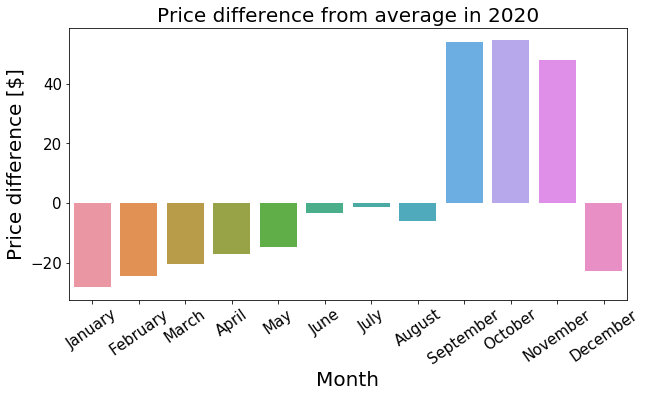

In [25]:
bar_plot(df_2020_month.index.month_name(),df_2020_month['diff mean'],'Month','Price difference [$]',
         'Price difference from average in 2020')



#### Result : September, October and November are the most expensive months. December,January and February are least expensive.

## 2. What types of rooms are available? What is the price difference according to room type?

In [21]:
#availability per room type
sf_listings.room_type.value_counts()
sf_houses = sf_listings.groupby(['room_type']).mean()['availability_365'].sort_values()
print(sf_houses)

room_type
Private room       140.102276
Hotel room         154.006494
Entire home/apt    154.833501
Shared room        229.491468
Name: availability_365, dtype: float64


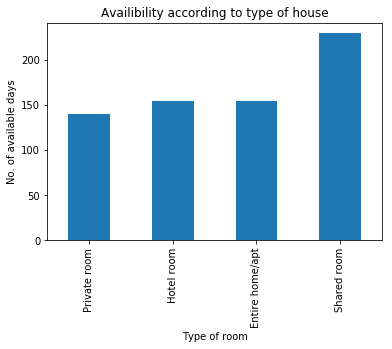

In [22]:
#plot availability vs room_type
sf_houses.plot(kind="bar");
plt.xlabel("Type of room")
plt.ylabel("No. of available days")
plt.title("Availibility according to type of house");

In [23]:
#checking if room_type has missing values
sf_listings.isnull().mean()

id                                0.000000
name                              0.000000
host_id                           0.000000
host_name                         0.006328
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.221610
reviews_per_month                 0.221610
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

room_type
Shared room         90.453925
Private room       140.253286
Hotel room         235.292208
Entire home/apt    269.363197
Name: price, dtype: float64


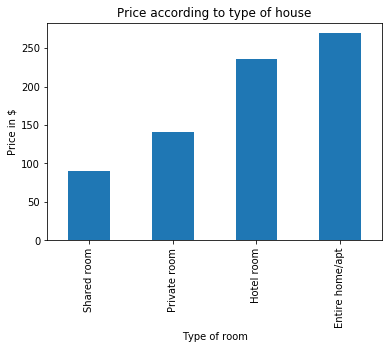

In [24]:
#average price per room type
sf_houses_price = sf_listings.groupby(['room_type']).mean()['price'].sort_values()
print(sf_houses_price)
sf_houses_price.plot(kind="bar");
plt.xlabel("Type of room")
plt.ylabel("Price in $")
plt.title("Price according to type of house");

#### Result : Shared room has highest availability and least price.


## 3. Which neighbourhood has most listings? Is price related to the number of listings in that neighbourhood?

In [25]:
#Number of listings per neighborhood
sf_listings['neighbourhood'].value_counts()

Mission                  789
Downtown/Civic Center    761
South of Market          751
Western Addition         630
Castro/Upper Market      471
Haight Ashbury           413
Bernal Heights           411
Noe Valley               336
Nob Hill                 324
Outer Sunset             319
Potrero Hill             250
Inner Richmond           227
Bayview                  226
Financial District       205
Marina                   194
North Beach              190
Russian Hill             189
Excelsior                189
Outer Richmond           188
Outer Mission            180
Inner Sunset             171
Pacific Heights          161
West of Twin Peaks       144
Ocean View               144
Parkside                 142
Chinatown                139
Visitacion Valley         76
Twin Peaks                69
Glen Park                 66
Lakeshore                 59
Crocker Amazon            49
Presidio Heights          23
Seacliff                  22
Diamond Heights           17
Golden Gate Pa

### Which neighbourhood has most availibility?

In [26]:
#available days per neighborhood
sf_listings_avail = sf_listings.groupby(['neighbourhood']).mean()['availability_365'].sort_values()
sf_listings_avail

neighbourhood
Treasure Island/YBI      101.500000
Diamond Heights          105.882353
Bernal Heights           110.732360
Glen Park                121.424242
Outer Sunset             127.946708
Parkside                 128.690141
Inner Richmond           132.414097
Financial District       132.453659
Castro/Upper Market      133.016985
Visitacion Valley        133.881579
Potrero Hill             134.416000
Inner Sunset             136.228070
Noe Valley               136.750000
Excelsior                137.444444
Mission                  137.711027
Chinatown                138.021583
Downtown/Civic Center    142.942181
Russian Hill             143.248677
Outer Mission            144.044444
Outer Richmond           146.489362
Ocean View               154.298611
Twin Peaks               154.333333
Bayview                  159.539823
Golden Gate Park         168.200000
Western Addition         169.177778
North Beach              170.052632
West of Twin Peaks       172.840278
Haight Ashbury

### Price variability with neighbourhood

In [27]:
#average price per neighborhood
sf_listings.groupby(['neighbourhood']).mean()['price'].sort_values()

neighbourhood
Treasure Island/YBI       97.500000
Presidio                 105.000000
Excelsior                119.862434
Bayview                  121.601770
Crocker Amazon           123.510204
Ocean View               124.902778
Outer Sunset             142.501567
Lakeshore                148.067797
Visitacion Valley        153.460526
Outer Mission            158.466667
Outer Richmond           178.579787
West of Twin Peaks       179.597222
Nob Hill                 185.750000
Chinatown                186.100719
Downtown/Civic Center    186.797635
Bernal Heights           191.250608
Diamond Heights          206.823529
Parkside                 207.239437
Inner Richmond           209.563877
Mission                  213.050697
Haight Ashbury           214.588378
Noe Valley               230.919643
Western Addition         233.138095
Financial District       233.365854
North Beach              236.700000
Glen Park                241.272727
Potrero Hill             245.856000
South of Marke

                        diff_mean
neighbourhood                    
Treasure Island/YBI   -117.912516
Presidio              -110.412516
Excelsior              -95.550082
Bayview                -93.810746
Crocker Amazon         -91.902312
Ocean View             -90.509738
Outer Sunset           -72.910949
Lakeshore              -67.344720
Visitacion Valley      -61.951990
Outer Mission          -56.945849
Outer Richmond         -36.832729
West of Twin Peaks     -35.815294
Nob Hill               -29.662516
Chinatown              -29.311797
Downtown/Civic Center  -28.614881
Bernal Heights         -24.161908
Diamond Heights         -8.588987
Parkside                -8.173079
Inner Richmond          -5.848639
Mission                 -2.361819
Haight Ashbury          -0.824138
Noe Valley              15.507127
Western Addition        17.725579
Financial District      17.953338
North Beach             21.287484
Glen Park               25.860211
Potrero Hill            30.443484
South of Marke

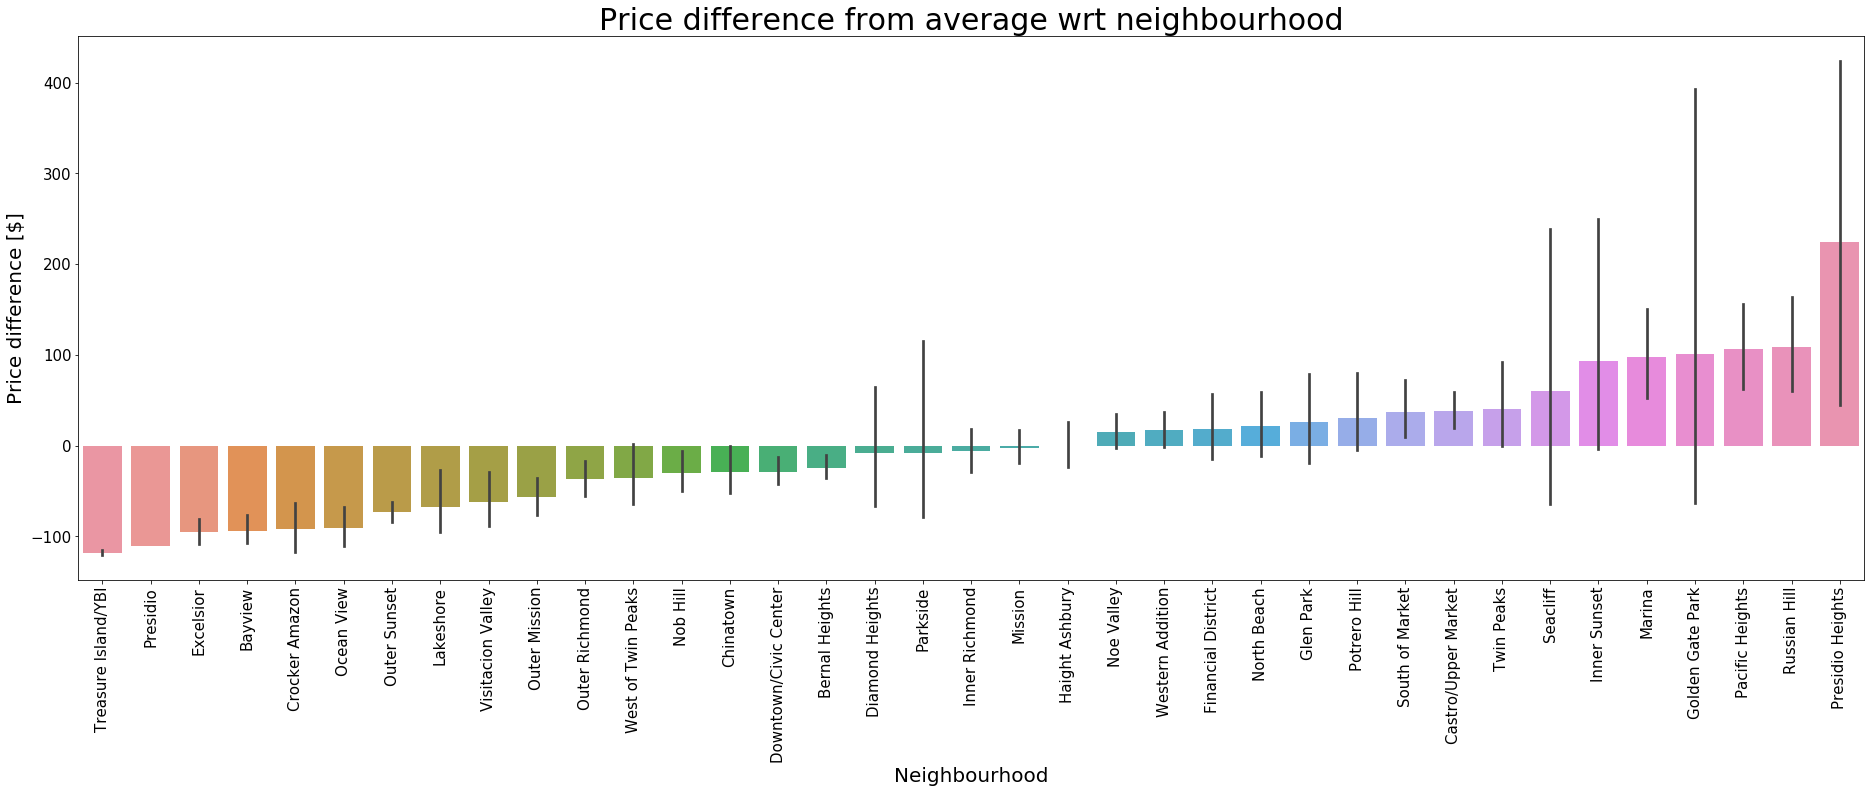

In [32]:
# difference between the price mean per month and the price mean
sf_listings['diff_mean'] = sf_listings['price'] - sf_listings['price'].mean()
sf_listings_sorted = sf_listings.groupby(['neighbourhood']).mean()['diff_mean'].sort_values()
c = sf_listings_sorted.to_frame()
print(c)
# Plot the price difference
fig2 = plt.figure(figsize=(32,10))
ax = fig2.add_subplot(1, 1, 1, aspect='auto')
sns.barplot(x = sf_listings['neighbourhood'], y = sf_listings['diff_mean'],order = c.index)
# Set axis label properties
ax.set_xlabel('Neighbourhood', weight='normal', size=20)
ax.set_ylabel('Price difference [$]', weight='normal', size=20)
plt.title('Price difference from average wrt neighbourhood', fontsize=30)
# Set tick label properties
ax.tick_params('x', labelsize=15, rotation=90)
ax.tick_params('y', labelsize=15)
plt.show()

#### Result : Mission,Downtown and South of Market have most listings whereas Russian Hill, Pacific Heights, Golden Gate Park have highest number of days available (Note: Presidio Heights has only one listing so availability is not an accurate metric) and are the most expensive.
